In [139]:
import numpy as np
import pandas as pd
import feather

from scipy.stats import kurtosis, skew
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [200]:
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60
plt.style.use("tableau-colorblind10")

For details on how the dataframe was cleaned see gstore_revenue_cleaning. 

#### NOTE: Revenue has already been logtransformed here, so the numbers quoted will be Log(Transaction Revenue +1). For convenience will sometimes just refer to it as revenue

In [3]:
train_df = feather.read_dataframe('data/clean_train_v2.feather')

# Initial Exploratory Analysis

## Target Variable Distributions

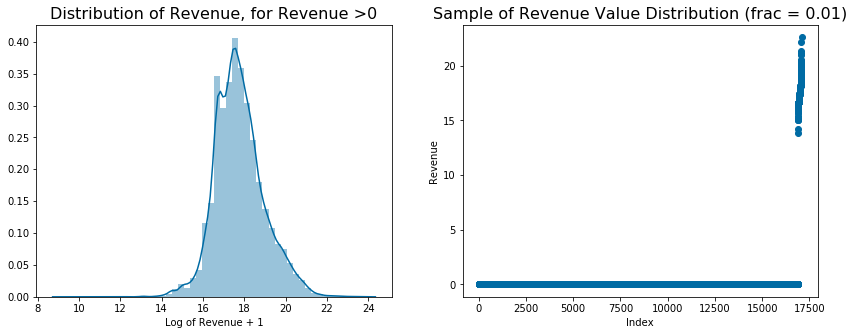

In [4]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(train_df[train_df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"],hist = True, bins = 50)
ax.set_xlabel('Log of Revenue + 1')
ax.set_title('Distribution of Revenue, for Revenue >0', fontsize = 16)

plt.subplot(1,2,2)
plt.scatter(range(train_df.sample(frac = 0.01, random_state = 1).shape[0]), np.sort(train_df.sample(frac = 0.01, random_state = 1)['totals.transactionRevenue'].values))
plt.xlabel('Index')
plt.ylabel('Revenue')
plt.title('Sample of Revenue Value Distribution (frac = 0.01)', fontsize = 16);

In [5]:
kurtosis(train_df[train_df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"])

1.057531376381153

In [6]:
skew(train_df[train_df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"])

0.38092213710384065

Relative high kurtosis, moderate skew. 

## ARPU, ARPPU

In [8]:
userTotalRev = train_df[['fullVisitorId', 'totals.totalTransactionRevenue', 'spender']].drop_duplicates()

In [9]:
userTotalRev['totals.totalTransactionRevenue'].sum()/len(userTotalRev)

0.24854345338929923

In [10]:
userTotalRev.loc[userTotalRev['spender']]['totals.totalTransactionRevenue'].sum()/len(userTotalRev.loc[userTotalRev['spender']])

20.38315008704648

Right now will not split this by different dimensions.
Want to come back and find a way to ensure that every fullVisitorId only has one channelGrouping? 
Not sure how to do that right now. 

## Transaction Revenue By Other Dimensions
### Channel Grouping

Most popular browser channelGrouping is OrganicSearch

But Referal, Display, and Paid Search result in the highest conversion rates to spending per transaction.

But when just considering spending transactions the different channelGroupings the highest median transaction revenue comes from Display, with Affiliates the lowest.
(Just one transaction for (Other))

In [11]:
train_df.loc[(train_df['channelGrouping'] == '(Other)') & (train_df['totals.transactionRevenue'] > 0)]

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.timeOnSite,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,_weekday,_day,_month,_year,_visitHour,trafficSource.campaignCode,totals.totalTransactionRevenue,spender
1560539,(Other),2017-04-18,9907138721210043039,1492543413,1,1492543413,Chrome,iOS,True,mobile,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,San Jose,(not set),1,17,16,0,1,356,16.117095,(not set),google,(not set),False,True,1,18,4,2017,19,None,16.117095,True


In [12]:
channelGrouping_pct = pd.DataFrame(np.round(100*(train_df.groupby('channelGrouping')['totals.transactionRevenue'].count()/len(train_df)),2)).reset_index()

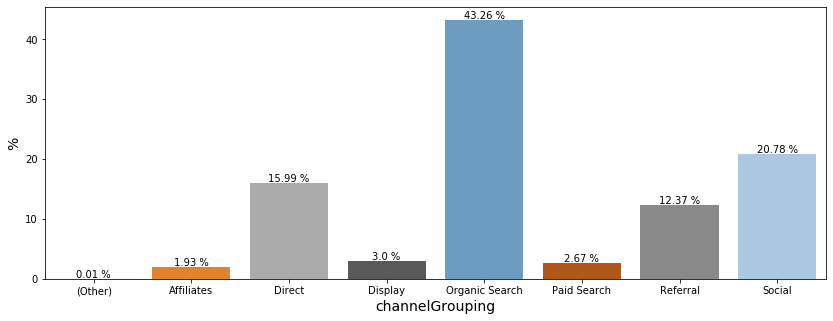

In [13]:
plt.figure(figsize = (14,5))
g = sns.barplot(x = 'channelGrouping', y = 'totals.transactionRevenue', data = channelGrouping_pct)
for index, row in channelGrouping_pct.iterrows():
    g.text(row.name, row['totals.transactionRevenue']+0.2, str(row['totals.transactionRevenue'])+" %", color='black', ha="center")
plt.ylabel('%', fontsize = 14)
plt.xlabel('channelGrouping', fontsize = 14);

In [14]:
channelGrouping_pct_spenders = pd.DataFrame(np.round(100*train_df.loc[train_df['totals.transactionRevenue']> 0].groupby('channelGrouping')['totals.transactionRevenue'].count()\
/train_df.groupby('channelGrouping')['totals.transactionRevenue'].count(),2)).reset_index().fillna(0)

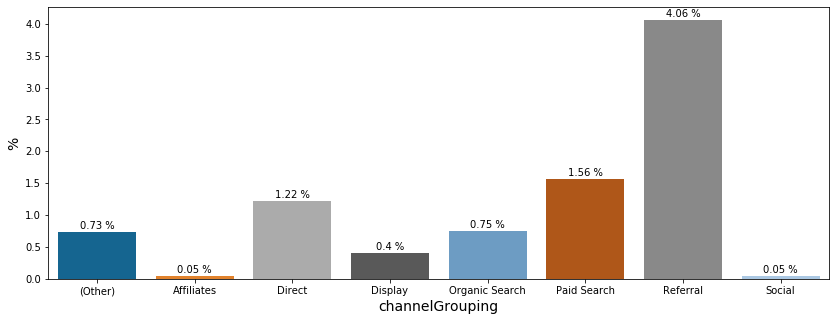

In [15]:
plt.figure(figsize = (14,5))
g = sns.barplot(x = 'channelGrouping', y = 'totals.transactionRevenue', data = channelGrouping_pct_spenders)
for index, row in channelGrouping_pct_spenders.iterrows():
    g.text(row.name, row['totals.transactionRevenue']+0.05, str(row['totals.transactionRevenue'])+" %", color='black', ha="center")
plt.ylabel('%', fontsize = 14)
plt.xlabel('channelGrouping', fontsize = 14);

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


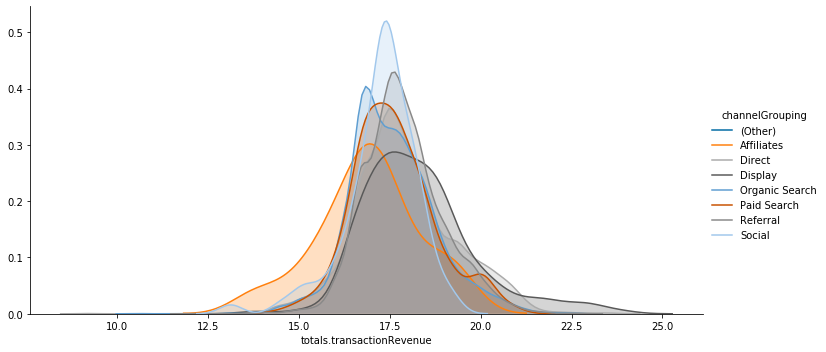

In [16]:
(sns.FacetGrid(train_df.loc[train_df['totals.transactionRevenue']> 0],hue='channelGrouping', height=5, aspect=2\
               ,hue_order = ['(Other)','Affiliates', 'Direct', 'Display', 'Organic Search', 'Paid Search', 'Referral', 'Social'])
 .map(sns.kdeplot, 'totals.transactionRevenue', shade=True )
 .add_legend()
);

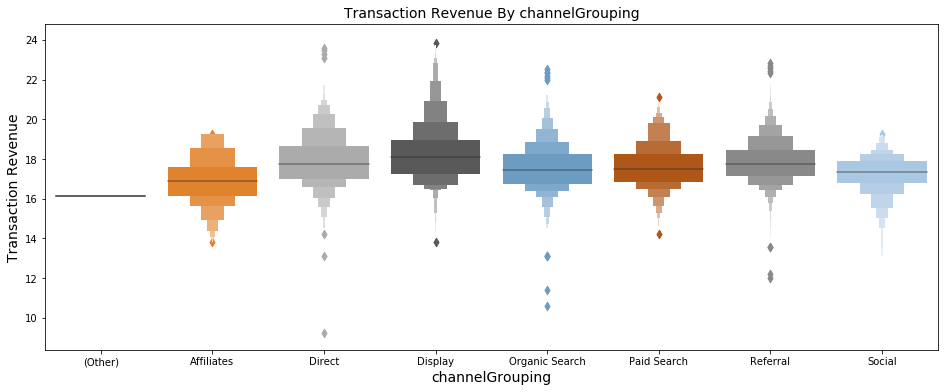

In [17]:
plt.figure(figsize = (16,6))
sns.boxenplot(x = 'channelGrouping', y='totals.transactionRevenue', data = train_df.loc[train_df['totals.transactionRevenue']> 0]\
             ,order = ['(Other)','Affiliates', 'Direct', 'Display', 'Organic Search', 'Paid Search', 'Referral', 'Social'])
plt.title('Transaction Revenue By channelGrouping', fontsize = 14)
plt.ylabel('Transaction Revenue', fontsize = 14)
plt.xlabel('channelGrouping', fontsize = 14);

In [18]:
channelGrouping_revenue = pd.DataFrame(train_df.loc[train_df['totals.transactionRevenue']> 0].groupby('channelGrouping')['totals.transactionRevenue'].agg(['mean', 'std', 'median'])).reset_index()

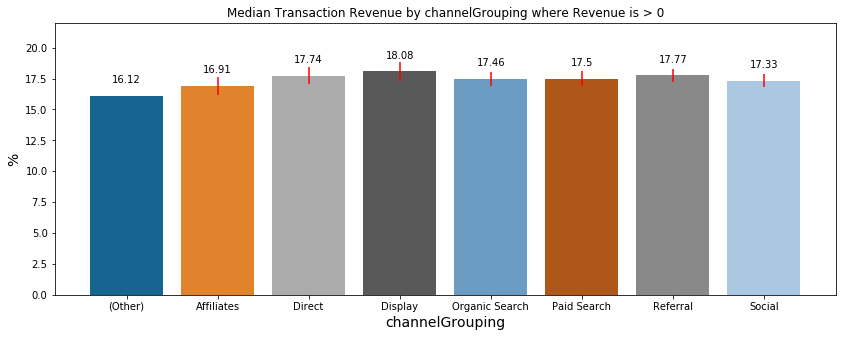

In [19]:
plt.figure(figsize = (14,5))
g = sns.barplot(x = 'channelGrouping', y = 'median', data = channelGrouping_revenue)
plt.errorbar(x = [0,1,2,3,4,5,6,7], y = channelGrouping_revenue['median'], yerr=channelGrouping_revenue['std']/2,fmt = 'none', c = 'r')
for index, row in channelGrouping_revenue.iterrows():
    g.text(row.name, row['median']+1.05, np.round(row['median'],2), color='black', ha="center")
plt.ylabel('%', fontsize = 14)
plt.xlabel('channelGrouping', fontsize = 14)
plt.ylim(0,22)
plt.title('Median Transaction Revenue by channelGrouping where Revenue is > 0');

Could play around with investigating all dimensions for ages.
will build an initial simple Random Forest Regressor to do some feature importance testing

To do that will need to sort out one hot encoding etc

In [20]:
del train_df

# Starting the Model

## Splitting the train set

In [3]:
train_df = feather.read_dataframe('data/encode_train_v2.feather')

In [4]:
train_df = train_df.sort_values('visitStartTime', ascending = True).reset_index(drop = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


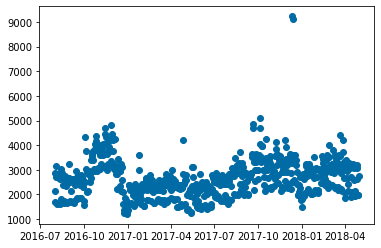

In [5]:
plt.plot_date(train_df['date'].value_counts().index, train_df['date'].value_counts().values);

In [6]:
test_df = feather.read_dataframe('data/encode_test_v2.feather')

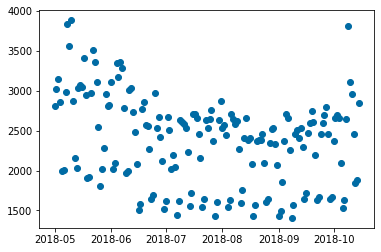

In [7]:
plt.plot_date(test_df['date'].value_counts().index, test_df['date'].value_counts().values);

In [8]:
train_df['date'].min()

Timestamp('2016-08-01 00:00:00')

In [9]:
train_df['date'].max()

Timestamp('2018-04-30 00:00:00')

In [10]:
test_df['date'].min()

Timestamp('2018-05-01 00:00:00')

Test dataset is after the train set. 

So when splitting training into validation set will take this into account. 

In [11]:
len(train_df)

1708337

In [12]:
len(test_df)

401589

In [13]:
len(test_df)/len(train_df)

0.23507598325154813

In [14]:
split_index = int(len(train_df)*(1-len(test_df)/len(train_df)))

In [15]:
len(train_df[:split_index])

1306748

In [16]:
train_set = train_df[:split_index]
valid_set = train_df[split_index:]

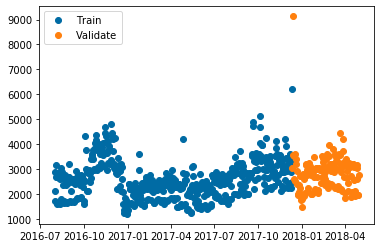

In [17]:
plt.plot_date(train_set['date'].value_counts().index, train_set['date'].value_counts().values)
plt.plot_date(valid_set['date'].value_counts().index, valid_set['date'].value_counts().values)
plt.legend(['Train', 'Validate']);

In [18]:
len(train_set.sample(frac = 0.1, random_state = 2))

130675

In [19]:
len(valid_set.sample(frac = 0.1, random_state = 2))

40159

In [20]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

## Do Sample First

In [94]:
train_sample = train_set.sample(frac = 0.1, random_state = 2).drop(['date', 'fullVisitorId','totals.totalTransactionRevenue', 'spender'], axis = 1)
train_ids = train_set.sample(frac = 0.1, random_state = 2)['fullVisitorId']

valid_sample = valid_set.sample(frac = 0.1, random_state = 2).drop(['date','fullVisitorId','totals.totalTransactionRevenue' ,'spender'], axis = 1)
valid_ids = valid_set.sample(frac = 0.1, random_state = 2)['fullVisitorId']

x_train = train_sample.drop('totals.transactionRevenue', axis = 1 )
y_train = train_sample['totals.transactionRevenue'].values

x_valid = valid_sample.drop('totals.transactionRevenue', axis = 1 )
y_valid = valid_sample['totals.transactionRevenue'].values

In [95]:
m = RandomForestRegressor()
m.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [119]:
def rmse(x,y): return np.sqrt(mean_squared_error(x, y))
def print_score(m):
    train_pred_df = pd.DataFrame({'fullVisitorId': train_ids, 'PredictedRevenue' :m.predict(x_train), 'ActualRevenue':train_sample['totals.transactionRevenue'] })
    train_pred_df = train_pred_df.groupby('fullVisitorId', as_index = False).sum()
    val_pred_df = pd.DataFrame({'fullVisitorId': valid_ids, 'PredictedRevenue' :m.predict(x_valid), 'ActualRevenue':valid_sample['totals.transactionRevenue']})
    val_pred_df = val_pred_df.groupby('fullVisitorId', as_index = False).sum()
    
    
    res = [rmse(train_pred_df['PredictedRevenue'], train_pred_df['ActualRevenue']), rmse(val_pred_df['PredictedRevenue'].values, val_pred_df['ActualRevenue']),
          m.score(x_train, y_train), m.score(x_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    

In [122]:
print_score(m)

[0.7490972244898496, 2.0804797557756, 0.8591291642936719, -0.5402361322527189]


Looks to be overfitting quite badly

In [123]:
preds = np.stack([t.predict(x_valid) for t in m.estimators_])

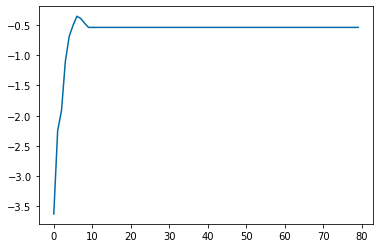

In [124]:
plt.plot([r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(80)]);

Num estimators defaults to 10, doesn't look like adding more will help

In [125]:
m = RandomForestRegressor(n_estimators=10)
m.fit(x_train, y_train)
print_score(m)

[0.7449189576076248, 2.4605140747255323, 0.8602912033819615, -1.1365836473706064]


In [126]:
m = RandomForestRegressor(n_estimators=20)
m.fit(x_train, y_train)
print_score(m)

[0.6872316620243435, 2.1413004295612867, 0.8815910418161279, -0.6158366663422739]


In [127]:
m = RandomForestRegressor(n_estimators=40)
m.fit(x_train, y_train)
print_score(m)

[0.6490172665969023, 2.0624893440398715, 0.8949363216406468, -0.5108477346630544]


In [128]:
m = RandomForestRegressor(n_estimators=40, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[0.655431249575661, 2.1673932078862648, 0.8924567092477524, -0.6658240008113527, 0.23993906882374993]


Out of bag score better than validation score, but worse than train. Different time and overfitting an issue.

min_samples_leaf gross the trees less deeply. Requiring some minimum number of rows in each leaf. This results in: 
* There are less decision rules for each leaf node; simpler models should generalize better
* The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [129]:
m = RandomForestRegressor(n_estimators=40,min_samples_leaf = 3, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[1.011200159454678, 1.5547604332604306, 0.745051482691526, 0.13699756802371577, 0.2735937405957455]


In [130]:
m = RandomForestRegressor(n_estimators=40,min_samples_leaf = 30, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[1.55916663560359, 1.431218057928997, 0.40002326412100975, 0.25437336794148235, 0.3030321302530874]


In [131]:
m = RandomForestRegressor(n_estimators=40,min_samples_leaf = 10, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[1.375002298926138, 1.4541044010339963, 0.5295886573633448, 0.23395282967209308, 0.29717278295894867]


max_features should help with generalisation as it samples number of columns to use for each split. 

In [134]:
m = RandomForestRegressor(n_estimators=40,min_samples_leaf = 30, max_features = 0.5,  oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[1.5732995976876505, 1.4316400883744986, 0.3903534883807178, 0.25338473222210833, 0.3030892910448858]


However including max features this time has no positive impact

## Best Right Now

In [135]:
m = RandomForestRegressor(n_estimators=40,min_samples_leaf = 3, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[1.013067114655122, 1.538958771303156, 0.7446182196198828, 0.15042992206391015, 0.27217735587813063]


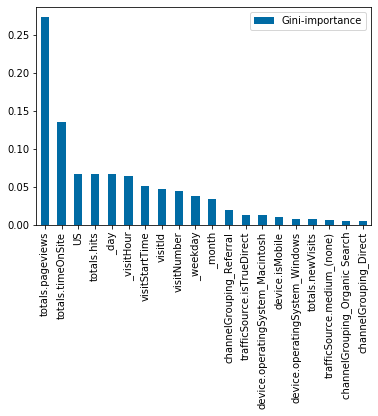

In [145]:
num_feats = 20
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, m.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending = False)[:num_feats].plot(kind='bar');

## Keep The best and do full data

In [236]:
to_keep = importances.sort_values(by='Gini-importance', ascending = False)[:num_feats].index.tolist() + ['totals.transactionRevenue']

In [239]:
train_full = train_set[to_keep]
train_ids = train_set['fullVisitorId']

valid_full = valid_set[to_keep]
valid_ids = valid_set['fullVisitorId']

x_train = train_full.drop('totals.transactionRevenue', axis = 1 )
y_train = train_full['totals.transactionRevenue'].values

x_valid = valid_full.drop('totals.transactionRevenue', axis = 1 )
y_valid = valid_full['totals.transactionRevenue'].values

In [240]:
m = RandomForestRegressor(n_estimators=40,min_samples_leaf = 3, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[2.0722497851810404, 1.5679262642538863, 0.7525964369710357, 0.1470051128057489, 0.29830662915864714]


In [241]:
train_pred_df = pd.DataFrame({'fullVisitorId': train_ids, 'PredictedRevenue' :m.predict(x_train), 'ActualRevenue':train_sample['totals.transactionRevenue'] })
train_pred_df = train_pred_df.groupby('fullVisitorId', as_index = False).sum()
val_pred_df = pd.DataFrame({'fullVisitorId': valid_ids, 'PredictedRevenue' :m.predict(x_valid), 'ActualRevenue':valid_sample['totals.transactionRevenue']})
val_pred_df = val_pred_df.groupby('fullVisitorId', as_index = False).sum()

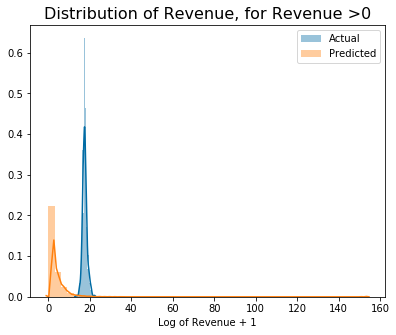

In [245]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(val_pred_df[val_pred_df['ActualRevenue'] > 0]["ActualRevenue"],hist = True, bins = 50)
ax = sns.distplot(val_pred_df[val_pred_df['PredictedRevenue'] > 0]["PredictedRevenue"],hist = True, bins = 50)
plt.legend(['Actual', 'Predicted'])
ax.set_xlabel('Log of Revenue + 1')
ax.set_title('Distribution of Revenue, for Revenue >0', fontsize = 16);

First pass, but looks quite bad to be honest. Will go back and keep all categories etc

## Related Columns

In [172]:
from scipy.cluster import hierarchy as hc

In [209]:
corr = np.round(scipy.stats.spearmanr(x_train.drop('totals.visits', axis = 1)).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr, checks = False)
z = hc.linkage(corr_condensed, method='average')

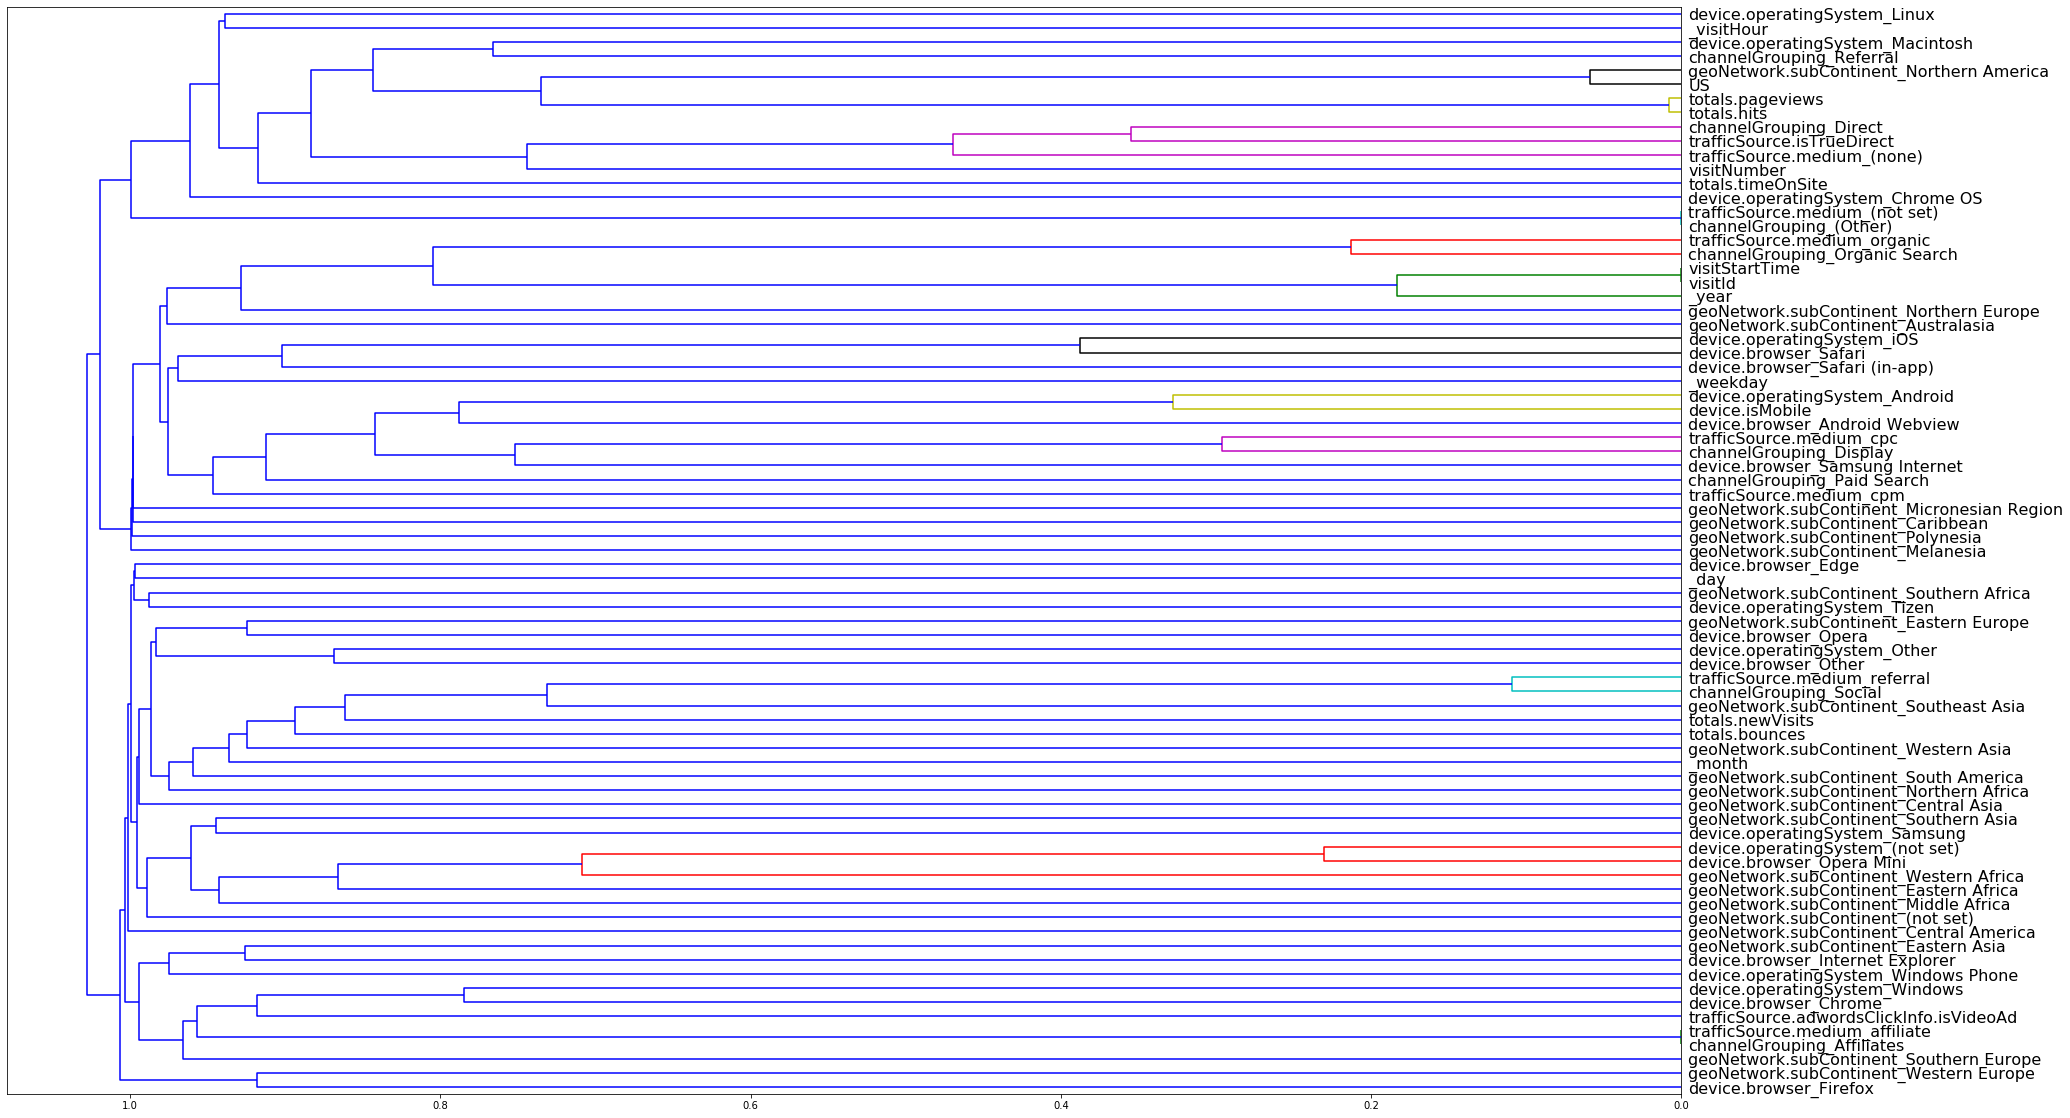

In [211]:
fig = plt.figure(figsize=(30,20))
dendrogram = hc.dendrogram(z, labels=x_train.drop('totals.visits', axis = 1).columns, orientation='left', leaf_font_size=16);

In [213]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40,min_samples_leaf = 3, n_jobs=-1, oob_score=True)
    m.fit(x_train, y_train)
    return m.oob_score_

In [221]:
get_oob(x_train)

0.27718631002465566

In [219]:
for c in ('US', 'geoNetwork.subContinent_Northern America', 'totals.hits', 'totals.pageviews', 'channelGrouping_Direct',\
          'trafficSource.isTrueDirect', 'visitId', 'visitStartTime', '_year', 'device.operatingSystem_Android', 'device.isMobile'):
    print(c, get_oob(x_train.drop(c, axis=1)))

US 0.27406436977346027
geoNetwork.subContinent_Northern America 0.276025190064079
totals.hits 0.2695710718347327
totals.pageviews 0.276786749519604
channelGrouping_Direct 0.26836042217215217
trafficSource.isTrueDirect 0.276873348141755
visitId 0.2719072412498259
visitStartTime 0.2765180283472646
_year 0.27098280582632384
device.operatingSystem_Android 0.27701036828446923
device.isMobile 0.2672718673394585
